# Introduction
This notebook demonstrates a comprehensive analysis workflow using NBC show details and pilot survey data. We begin by exploring and visualizing the data through exploratory data analysis (EDA) to understand key attributes such as projected engagement (PE) and gross rating points (GRP) across different genres. Next, we apply dimensionality reduction via Principal Component Analysis (PCA) on aggregated survey responses to identify underlying patterns in viewer perceptions. We then compare several Lasso regression models—one using the original survey variables, another using principal components (PCs), and finally a combined model—to predict projected engagement. This approach not only illustrates practical data science techniques for handling multicollinearity and high-dimensional data but also emphasizes careful cross-validation to avoid data leakage during model evaluation.

Exploratory analysis

First few rows of showdetails:
                        Show Network       PE    GRP            Genre  \
0             Living with Ed    HGTV  54.0000  151.0          Reality   
1               Monarch Cove    LIFE  64.6479  375.5  Drama/Adventure   
2                   Top Chef   BRAVO  78.5980  808.5          Reality   
3          Iron Chef America    FOOD  62.5703   17.3          Reality   
4  Trading Spaces: All Stars     TLC  56.0000   44.1          Reality   

   Duration  
0        30  
1        60  
2        60  
3        30  
4        60   

Summary statistics of showdetails:
              PE          GRP   Duration
count  40.000000    40.000000  40.000000
mean   72.683075   823.905000  50.250000
std    12.032495   683.418003  14.230249
min    30.000000     7.500000  30.000000
25%    64.575300   301.450000  30.000000
50%    77.055450   647.900000  60.000000
75%    80.159425  1200.450000  60.000000
max    89.294800  2773.800000  60.000000 

Missing values in 'PE': 0
Missing valu

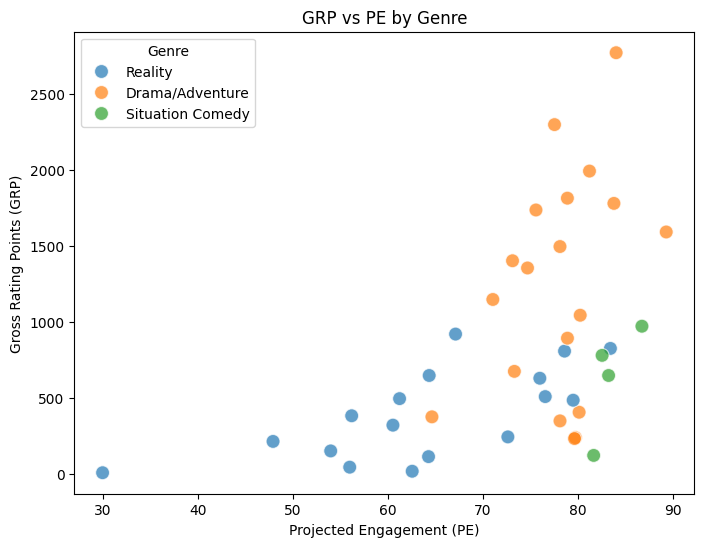

In [1]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# (1) Read in the CSV files
# Adjust the file paths as needed
showdetails = pd.read_csv("nbc_showdetails.csv")
pilotsurvey = pd.read_csv("nbc_pilotsurvey.csv")

# (2) Optional EDA checks: view the first few rows, summary statistics, and check missing data
print("First few rows of showdetails:")
print(showdetails.head(), "\n")

print("Summary statistics of showdetails:")
print(showdetails.describe(), "\n")

print("Missing values in 'PE':", showdetails['PE'].isna().sum())
print("Missing values in 'GRP':", showdetails['GRP'].isna().sum(), "\n")

print("Frequency of each Genre:")
print(showdetails['Genre'].value_counts(), "\n")

# (3) Plot GRP vs PE, colored by Genre
plt.figure(figsize=(8,6))
sns.scatterplot(data=showdetails, x='PE', y='GRP', hue='Genre', s=100, alpha=0.7)
plt.title("GRP vs PE by Genre")
plt.xlabel("Projected Engagement (PE)")
plt.ylabel("Gross Rating Points (GRP)")
plt.show()


PCA on Averaged Pilot Survey Responses

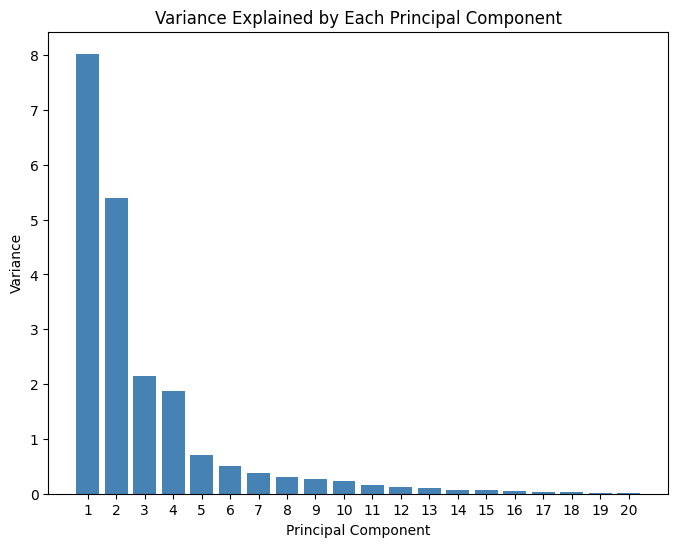

In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# (1) Define the list of question columns (assuming these names match your CSV)
question_cols = ["Q1_Attentive", "Q1_Excited", "Q1_Happy", "Q1_Engaged", "Q1_Curious",
                 "Q1_Motivated", "Q1_Comforted", "Q1_Annoyed", "Q1_Indifferent",
                 "Q2_Relatable", "Q2_Funny", "Q2_Confusing", "Q2_Predictable",
                 "Q2_Entertaining", "Q2_Fantasy", "Q2_Original", "Q2_Believable",
                 "Q2_Boring", "Q2_Dramatic", "Q2_Suspenseful"]

# (2) Group by 'Show' and compute the mean for each question column
avg_responses = pilotsurvey.groupby('Show')[question_cols].mean().reset_index()
# Use 'Show' as the index
avg_responses.set_index('Show', inplace=True)

# (3) Convert the summarized data to a matrix (rows: shows, columns: question averages)
X_mat = avg_responses.values

# (4) Perform PCA on X_mat after standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mat)
pca = PCA()  # By default, PCA computes as many components as features
pca.fit(X_scaled)

# (5) Extract the variance explained by each principal component
pc_variances = pca.explained_variance_

# (6) Plot the variance explained by each principal component
plt.figure(figsize=(8,6))
plt.bar(range(1, len(pc_variances)+1), pc_variances, color="steelblue")
plt.xlabel("Principal Component")
plt.ylabel("Variance")
plt.title("Variance Explained by Each Principal Component")
plt.xticks(range(1, len(pc_variances)+1))
plt.show()


Interpreting Principal Component Loadings

In [3]:
# (1) Extract the loadings (each column in pca.components_.T corresponds to a PC)
loadings = pca.components_.T  # shape: (n_features, n_components)

# Extract loadings for PC1 and PC2
pc1_loadings = loadings[:, 0]
pc2_loadings = loadings[:, 1]

# Create a DataFrame for easier interpretation
loadings_df = pd.DataFrame(loadings, index=question_cols,
                           columns=[f"PC{i}" for i in range(1, loadings.shape[1]+1)])

# Sort loadings for PC1
pc1_sorted = loadings_df['PC1'].sort_values(ascending=False)
pc1_sorted_abs = loadings_df['PC1'].abs().sort_values(ascending=False)

print("PC1 Loadings (sorted by value):")
print(pc1_sorted, "\n")

print("PC1 Loadings (sorted by absolute value):")
print(pc1_sorted_abs, "\n")

# Sort loadings for PC2
pc2_sorted = loadings_df['PC2'].sort_values(ascending=False)
pc2_sorted_abs = loadings_df['PC2'].abs().sort_values(ascending=False)

print("PC2 Loadings (sorted by value):")
print(pc2_sorted, "\n")

print("PC2 Loadings (sorted by absolute value):")
print(pc2_sorted_abs)


PC1 Loadings (sorted by value):
Q1_Attentive       0.343650
Q1_Engaged         0.339703
Q1_Excited         0.312611
Q2_Suspenseful     0.302003
Q1_Curious         0.293097
Q2_Original        0.269973
Q2_Entertaining    0.265329
Q1_Motivated       0.238482
Q2_Dramatic        0.217957
Q1_Comforted       0.144996
Q2_Fantasy         0.133780
Q1_Happy           0.130375
Q2_Confusing       0.102021
Q2_Relatable       0.091980
Q2_Believable      0.058611
Q2_Funny          -0.114727
Q1_Indifferent    -0.169066
Q2_Boring         -0.176337
Q1_Annoyed        -0.199689
Q2_Predictable    -0.230360
Name: PC1, dtype: float64 

PC1 Loadings (sorted by absolute value):
Q1_Attentive       0.343650
Q1_Engaged         0.339703
Q1_Excited         0.312611
Q2_Suspenseful     0.302003
Q1_Curious         0.293097
Q2_Original        0.269973
Q2_Entertaining    0.265329
Q1_Motivated       0.238482
Q2_Predictable     0.230360
Q2_Dramatic        0.217957
Q1_Annoyed         0.199689
Q2_Boring          0.176337
Q1_

The first principal component (PC1) shows its largest positive loadings on variables like Q1_Attentive, Q1_Engaged, Q1_Excited, Q2_Suspenseful, and Q1_Curious. In contrast, it has large negative loadings on Q2_Predictable, Q1_Annoyed, Q2_Boring, and Q1_Indifferent. This suggests that PC1 captures a spectrum from shows that are engaging and suspenseful to those that are predictable or boring. Similarly, PC2 separates shows based on another mix of attributes as indicated by its loadings.



Lasso Regression on the Original 20 Questions

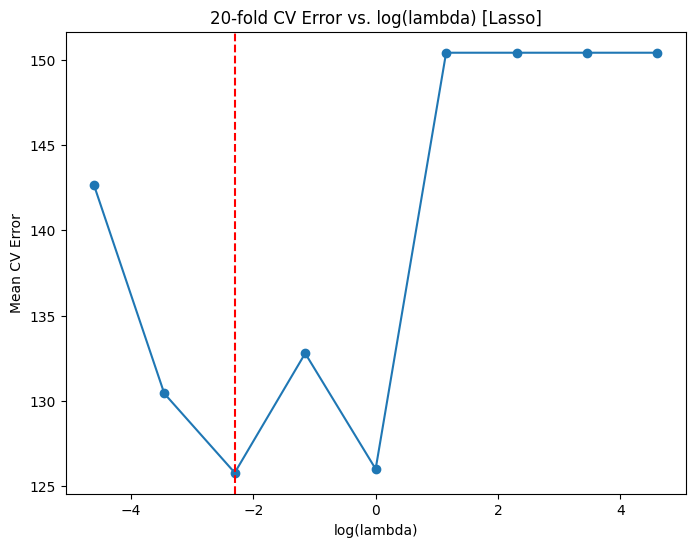

In [4]:
from sklearn.linear_model import LassoCV

# (1) Merge showdetails and the averaged responses by 'Show'
merged_data = pd.merge(showdetails, avg_responses, left_on="Show", right_index=True, how="inner")

# (2) Create design matrix X (using the 20 question averages) and response vector y (PE)
X = merged_data[question_cols].values
y = merged_data['PE'].values

# (3) Define a grid of lambda values (in sklearn, the regularization parameter is 'alpha')
lambda_grid = 10 ** np.arange(-2, 2.5, 0.5)  # from 10^-2 to 10^2 in increments

# (4) Fit a Lasso model using 20-fold cross-validation
lasso_cv = LassoCV(alphas=lambda_grid, cv=20, random_state=123, max_iter=10000)
lasso_cv.fit(X, y)

# (5) Plot the cross-validation error versus log(lambda)
mse_mean = np.mean(lasso_cv.mse_path_, axis=1)
plt.figure(figsize=(8,6))
plt.plot(np.log(lasso_cv.alphas_), mse_mean, marker='o')
plt.xlabel("log(lambda)")
plt.ylabel("Mean CV Error")
plt.title("20-fold CV Error vs. log(lambda) [Lasso]")
plt.axvline(np.log(lasso_cv.alpha_), color='red', linestyle='--')
plt.show()


Lasso Regression Using Principal Components

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize X and compute principal components
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pc_scores = pca.fit_transform(X_scaled)  # This creates the pc_scores variable


In [9]:
# Compute PCA on the original X
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
pca_pc = PCA()
pc_scores = pca_pc.fit_transform(X_scaled)

# Fit the Lasso model using PC scores
lasso_cv_pc = LassoCV(alphas=lambda_grid, cv=20, random_state=123, max_iter=10000)
lasso_cv_pc.fit(pc_scores, y)

# Compute the mean CV error across folds for each lambda
mse_mean_pc = np.mean(lasso_cv_pc.mse_path_, axis=1)


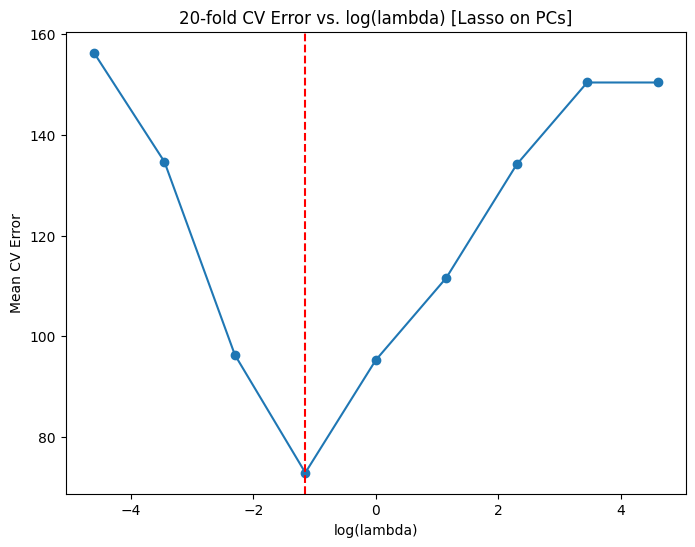

Min CV error (PC-based) = 72.88906730073094
Min CV error (Original) = 125.79211715987742


In [11]:
# (1) Compute PCA on the design matrix X after standardization
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
pca_pc = PCA()
pc_scores = pca_pc.fit_transform(X_scaled)  # Each column is a principal component

# (2) Fit a Lasso model on the PC scores with 20-fold CV
lasso_cv_pc = LassoCV(alphas=lambda_grid, cv=20, random_state=123, max_iter=10000)
lasso_cv_pc.fit(pc_scores, y)

# (3) Plot the CV error vs. log(lambda) for the PC-based regression
mse_mean_pc = np.mean(lasso_cv_pc.mse_path_, axis=1)
plt.figure(figsize=(8,6))
plt.plot(np.log(lasso_cv_pc.alphas_), mse_mean_pc, marker='o')
plt.xlabel("log(lambda)")
plt.ylabel("Mean CV Error")
plt.title("20-fold CV Error vs. log(lambda) [Lasso on PCs]")
plt.axvline(np.log(lasso_cv_pc.alpha_), color='red', linestyle='--')
plt.show()

print("Min CV error (PC-based) =", mse_mean_pc.min())
print("Min CV error (Original) =", np.mean(lasso_cv.mse_path_, axis=1).min())


When the PC-based model has a lower CV error than the model using the original variables, it indicates that PCA has effectively “denoised” the data by focusing on the key sources of variation.

Lasso Regression Using Both Original Variables and PCs

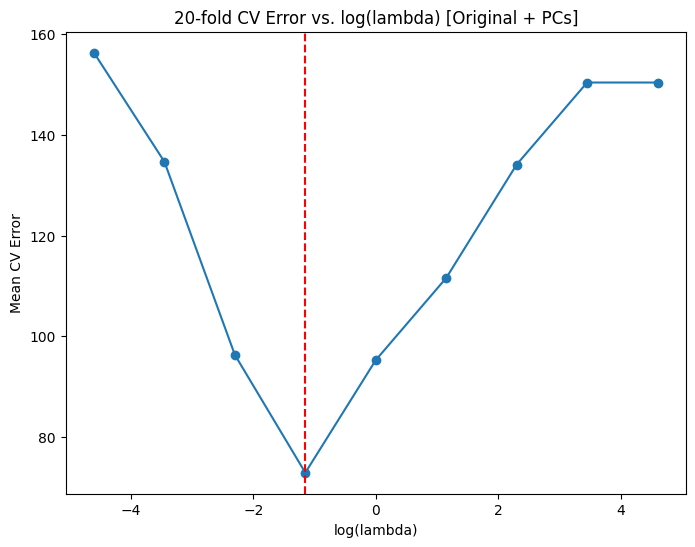

Min CV error (Original + PCs) = 72.88861963163825
Min CV error (Original)       = 125.79211715987742
Min CV error (PC-based)       = 72.88906730073094


In [12]:
# (1) Combine the original variables and the PC scores into one matrix
X_plus_PCs = np.hstack([X, pc_scores])  # This results in a 40 x 40 matrix (20 original + 20 PCs)

# (2) Fit a Lasso model via 20-fold CV using the combined predictors
lasso_cv_both = LassoCV(alphas=lambda_grid, cv=20, random_state=123, max_iter=10000)
lasso_cv_both.fit(X_plus_PCs, y)

# (3) Plot the CV error versus log(lambda)
mse_mean_both = np.mean(lasso_cv_both.mse_path_, axis=1)
plt.figure(figsize=(8,6))
plt.plot(np.log(lasso_cv_both.alphas_), mse_mean_both, marker='o')
plt.xlabel("log(lambda)")
plt.ylabel("Mean CV Error")
plt.title("20-fold CV Error vs. log(lambda) [Original + PCs]")
plt.axvline(np.log(lasso_cv_both.alpha_), color='red', linestyle='--')
plt.show()

print("Min CV error (Original + PCs) =", mse_mean_both.min())
print("Min CV error (Original)       =", np.mean(lasso_cv.mse_path_, axis=1).min())
print("Min CV error (PC-based)       =", mse_mean_pc.min())


Although adding the original variables to the PCs can offer some improvement over using just the original variables, it might not outperform using the PCs alone. This suggests that the PCs capture most of the predictive information in a more compact form; including the original variables can add redundancy that the Lasso model may not fully filter out.


In this example, we “cheated” by computing the principal components on the entire data set and then using those same PCs for every fold in cross‑validation. In a perfectly rigorous procedure, you would recompute the PCA within each fold (using only the training data) to ensure that no information from the test folds is used during feature extraction.

However, since PCA does not use the response variable
𝑦
y, this leakage is less severe than if the outcome were involved in the preprocessing. Nonetheless, it’s important to recognize that the number of PCs is part of the model-building process; if you tune it along with lambda, the entire PCA + Lasso pipeline should be refit inside each cross‑validation fold to avoid bias.



# Conclusion
In this analysis, we successfully integrated traditional EDA, PCA for dimensionality reduction, and Lasso regression to predict show engagement based on pilot survey data. The results indicate that using principal components, which capture the most informative variation in the data, leads to improved predictive performance compared to using the original variables alone. Moreover, while combining both the original features and PCs offered some gains over using the original variables exclusively, the PC-based model achieved the lowest cross-validation error. This underscores the importance of feature extraction and careful model tuning in reducing noise and enhancing model accuracy. Overall, the notebook provides a step-by-step example of building, evaluating, and interpreting a regression model in a data-rich context.